### PROJETO  REDES SOCIAIS

**GRUPO D:** 
- ESTHER DAGIR
- FELIPE LEMOS
- JV PAZOTTI

**DESCRIÇÃO DATASET CORD19**

Artigos acadêmicos relacionados ao COVID-19 e suas variantes que integram o dataset CORD-19. Coleção mais extensa (+134.000 artigos) de pesquisa sobre coronavírus legível por máquina disponível para mineração de dados até o momento, solicitada pelo governo americano em conjunto com entidades de pesquisa sobre o vírus e suas variantes. 

### Importando as Bibliotecas


In [2]:
import pandas as pd
import seaborn as sns
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


### Dataset

In [ ]:
raw_data = pd.read_csv("data/metadata.csv")

In [ ]:
data = raw_data 

In [ ]:
data.info()

In [ ]:
df = data.copy().drop(columns=['pdf_json_files','pmc_json_files','arxiv_id','pmcid',
                               'mag_id','s2_id','sha','cord_uid','abstract','url','mag_id','publish_time',
                                  'source_x','license','who_covidence_id','pubmed_id'])


In [ ]:
df = df.dropna()
df

In [ ]:
df['authors'] = df['authors'].astype(str)

In [ ]:
df.info()

### Construindo a rede de coautoria

In [ ]:
len(df['authors'])

In [ ]:
coautorias = [] 

for authors in df['authors']:
    authors_list = authors.split('; ')
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
            pair = tuple(sorted([authors_list[i], authors_list[j]]))
            coautorias.append(pair)          
             

%time

In [ ]:
coautorias_unicas = []
coautorias_set = set()

for coautoria in coautorias:
    coautoria_ordenada = tuple(sorted(coautoria))
    if coautoria not in coautorias_set:
        coautorias_unicas.append(coautoria)
        coautorias_set.add(coautoria)

In [ ]:
coautorias_count = {}

for coautoria in coautorias_unicas:
    autor1, autor2 = coautoria
    
    coautorias_count[autor1] = coautorias_count.get(autor1, 0) + 1
    coautorias_count[autor2] = coautorias_count.get(autor2, 0) + 1


In [ ]:
coautorias_filtradas = []

for coautoria in coautorias_unicas:
    autor1, autor2 = coautoria
    
    if coautorias_count.get(autor1, 0) >= 3 and coautorias_count.get(autor1, 0) < 50 and coautorias_count.get(autor2, 0) >= 3 and coautorias_count.get(autor2, 0) <50:
        
        coautorias_filtradas.append(coautoria)

In [ ]:
inf_coautorias_count = {} #contagem entre autores influentes

for coautoria in coautorias_filtradas:
    autor1, autor2 = coautoria
    
    inf_coautorias_count[autor1] = inf_coautorias_count.get(autor1, 0) + 1
    inf_coautorias_count[autor2] = inf_coautorias_count.get(autor2, 0) + 1
    

In [ ]:
inf_coautorias_filtradas = []

for coautoria in coautorias_filtradas:
    autor1, autor2 = coautoria
    
    if inf_coautorias_count.get(autor1, 0) > 6 and inf_coautorias_count.get(autor2, 0) > 6:
        
        inf_coautorias_filtradas.append(coautoria)


In [3]:
import numpy as np


quantidades = list(inf_coautorias_count.values())

media = np.mean(quantidades)
mediana = np.median(quantidades)

print("Média: ", media)
print("Mediana: ", mediana)



NameError: name 'inf_coautorias_count' is not defined

In [4]:
g=gt_load('data/cord19_graph.net.gz')
# g = Graph(directed=False) # não dirigido

In [5]:
cord19 = gt_data(g)

In [6]:
n = g.num_vertices()
m =  g.num_edges()
max_edges = n * (n - 1) if g.is_directed() else n * (n - 1) // 2
d = m / max_edges

print('Número de vértices de g:', n)
print('Número de arestas de g:', m)
print('Máximo possível de arestas de g:', max_edges)
print('Densidade de g:', d)

Número de vértices de g: 9704
Número de arestas de g: 66805
Máximo possível de arestas de g: 47078956
Densidade de g: 0.001418999180865438


In [7]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())

cord19['degree'] = degrees
cord19

,coreness,degree
id,,
0,0.162791,10
1,0.078095,8
2,0.176607,12
3,0.046953,7
4,0.189650,14
...,...,...
9699,0.221435,18
9700,0.079222,8
9701,0.949768,34


In [8]:
cord19['degree'].value_counts()

8     1122
7     1099
9      930
10     795
12     604
11     576
13     442
15     413
14     382
18     377
16     296
17     284
19     228
20     183
29     132
33     128
2      122
25     120
27     120
22     119
23     116
21     112
28     108
30     104
3      103
1       93
34      75
26      63
32      63
4       61
39      47
44      47
35      45
5       42
24      26
31      26
6       25
37      18
40      14
36      14
38       9
43       7
41       5
45       4
42       4
46       1
Name: degree, dtype: int64

In [10]:
cord19.to_csv('data/cord19.csv')

count    9704.000000
mean       13.768549
std         7.913647
min         1.000000
25%         8.000000
50%        11.000000
75%        17.000000
max        46.000000
Name: degree, dtype: float64

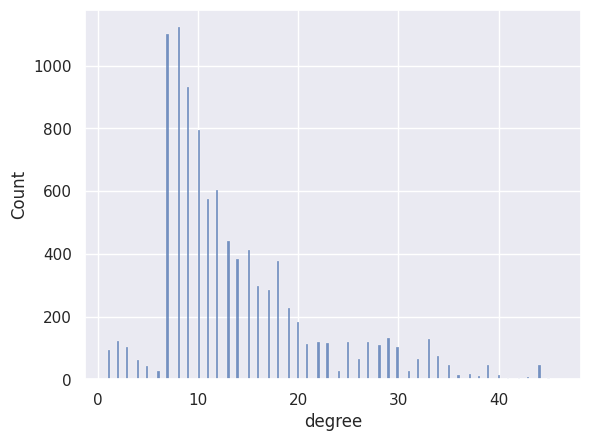

In [11]:
sns.histplot(cord19['degree'],bins=200)
cord19['degree'].describe()

In [12]:
gt_save(g, 'data/cord19_graph.net.gz')

In [13]:
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'data/cord19_graph.net.gz')
r = netpixi.render('data/cord19_graph.net.gz', infinite=True)